In [1]:
%matplotlib inline
from load_data import load
import numpy as np
import jax.numpy as jnp
from VarGMM import *
from cluster import reduce_to_threshold
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt
import seaborn as snb
from mpl_toolkits.mplot3d import Axes3D  

snb.set_style('darkgrid')
colors = snb.color_palette()
snb.set_theme(font_scale=1.1)


In [43]:
N = 14 #Components for clustering

raw_data, metadata = load("data/HR_data_2.csv")

# raw_data = raw_data[raw_data['Phase']=='phase3']
phase_values = raw_data['Phase'].to_numpy()  # <-- Save Phase values separately
raw_data = raw_data.drop(labels='Phase', axis=1)
 #One hot encode instructor?
data = reduce_to_threshold(raw_data)

data = data.to_numpy()
data = jnp.array(data)

data=data[:,:N] #two dimensional clustering only?
puzzler_vals = np.array(metadata['Puzzler'][:data.shape[0]])

raw_data = raw_data.to_numpy()
raw_data = jnp.array(raw_data)

print(data.shape)
D = data.shape[1]
D_raw = raw_data.shape[1]

(307, 14)


In [60]:
vi = VariationalGMM(D=D, K=2, alpha0=0.1, beta0 = 1)   
vi.fit(data.squeeze(), max_itt=10000, seed=2)

# vi_raw = VariationalGMM(D=D_raw, K=3, alpha0=0.01, beta0 = 0.1)   
# vi_raw.fit(raw_data.squeeze(), max_itt=10000, seed=2)

Converged in   59 iterations for K =  2 with lowerbound = -8394.757. Time = 1.91


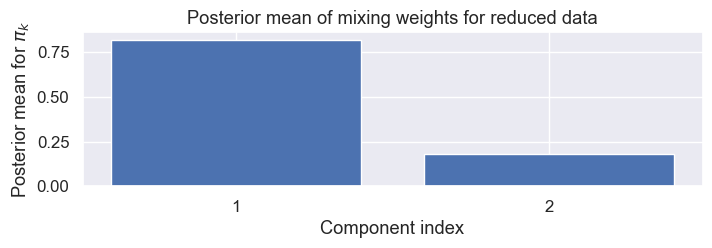

In [61]:
fig, ax = plt.subplots(1, 1, figsize=(8, 2))
ax.bar(jnp.arange(1, vi.K+1), vi.pi)
ax.set(xlabel='Component index', ylabel='Posterior mean for $\\pi_k$', title='Posterior mean of mixing weights for reduced data', xticks=jnp.linspace(1, vi.K, min(vi.K, 20)).round());

# fig, ax = plt.subplots(1, 1, figsize=(8, 2))
# ax.bar(jnp.arange(1, vi_raw.K+1), vi_raw.pi)
# ax.set(xlabel='Component index', ylabel='Posterior mean for $\\pi_k$', title='Posterior mean of mixing weights for raw data', xticks=jnp.linspace(1, vi_raw.K, min(vi_raw.K, 20)).round());

In [63]:
def print_results(clusters, metadata, metadata_vals, type):
    print(f"\nResults of type: {type}")
    # Initialize count matrix
    counts = np.zeros((len(clusters), len(metadata)), dtype=int)

    # Fill the matrix
    for i, cluster in enumerate(clusters):
        for j, m in enumerate(metadata):
            counts[i, j] = np.sum((ztrain == cluster) & (metadata_vals == m))

    # Print nicely
    for i, cluster in enumerate(clusters):
        print(f"\nCluster {cluster}:")
        for j, m in enumerate(metadata):
            print(f"{counts[i, j]} points")

def plot_data(data, labels, phase=None):
    x = data[:, 0]
    y = data[:, 1]
    
    num_classes = np.unique(labels)
    cmap = plt.get_cmap('tab10')

    markers = ['o', 's', 'D', '^', 'v', '<', '>', 'p', '*', 'h']  # marker styles
    unique_phases = np.unique(phase) if phase is not None else [None]

    fig, ax = plt.subplots(figsize=(8,6))

    # Plot points
    for cls in num_classes:
        for i, ph in enumerate(unique_phases):
            idx = (labels == cls)
            if phase is not None:
                idx = idx & (phase == ph)
            marker = markers[i % len(markers)]
            ax.scatter(x[idx], y[idx], 
                       color=cmap(cls), marker=marker, edgecolors='black', s=50)

    ax.set_xlabel('PC1')
    ax.set_ylabel('PC2')

    # Make custom legend for phase (shapes only)
    from matplotlib.lines import Line2D

    legend_elements = []
    for i, ph in enumerate(unique_phases):
        legend_elements.append(
            Line2D([0], [0], marker=markers[i % len(markers)], color='black', linestyle='None',
                   markersize=10, label=f'{ph}')
        )

    ax.legend(handles=legend_elements, title="Phase", loc='best')
    plt.show()

def three_d_plot_data(data, labels, phase=None):
    x = data[:, 0]
    y = data[:, 1]
    z = data[:, 2]
    
    num_classes = np.unique(labels)
    cmap = plt.get_cmap('tab10')

    markers = ['o', 's', 'D', '^', 'v', '<', '>', 'p', '*', 'h']  # marker styles
    unique_phases = np.unique(phase) if phase is not None else [None]

    fig = plt.figure(figsize=(12,8))
    ax = fig.add_subplot(111, projection='3d')

    # Plot points
    for cls in num_classes:
        for i, ph in enumerate(unique_phases):
            idx = (labels == cls)
            if phase is not None:
                idx = idx & (phase == ph)
            marker = markers[i % len(markers)]
            ax.scatter(x[idx], y[idx], z[idx], 
                       color=cmap(cls), marker=marker, edgecolors='black', s=50)

    ax.set_xlabel('PC1')
    ax.set_ylabel('PC2')
    ax.set_zlabel('PC3')

    # Make custom legend for phase (markers only)
    from matplotlib.lines import Line2D

    legend_elements = []
    for i, ph in enumerate(unique_phases):
        legend_elements.append(
            Line2D([0], [0], marker=markers[i % len(markers)], color='black', linestyle='None',
                   markersize=10, label=f'{ph}')
        )

    ax.legend(handles=legend_elements, title="Phase", loc='best')
    plt.show()



ptrain = vi.compute_component_probs(data)
ztrain = jnp.argmax(ptrain, axis=1)
clusters = np.unique(ztrain)

phase_classes = np.unique(phase_values[:data.shape[0]])
phase_vals = np.array(phase_values[:data.shape[0]])

puzzler_classes = np.unique(puzzler_vals)



print_results(clusters, phase_classes, phase_vals, type="Phases")

puzzler_classes = np.unique(metadata['Puzzler'][:data.shape[0]])
puzzler_vals = np.array(metadata['Puzzler'][:data.shape[0]])

print_results(clusters, puzzler_classes, puzzler_vals, type="Puzzler")



Results of type: Phases

Cluster 0:
87 points
81 points
85 points

Cluster 1:
15 points
21 points
18 points

Results of type: Puzzler

Cluster 0:
136 points
117 points

Cluster 1:
20 points
34 points


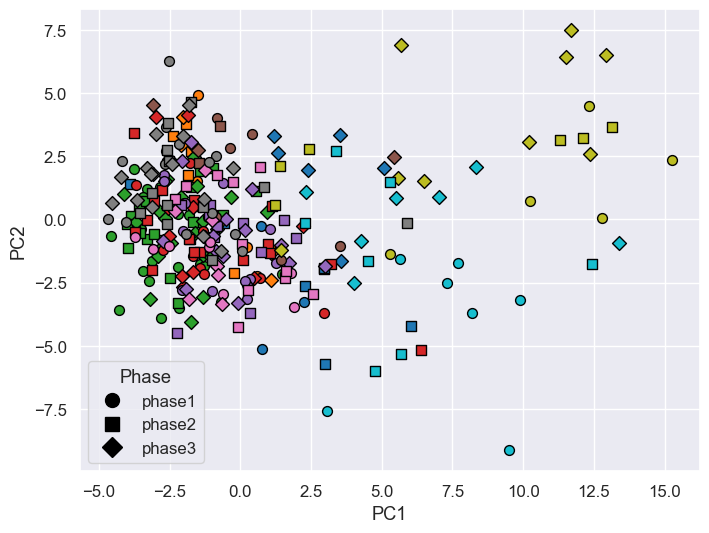

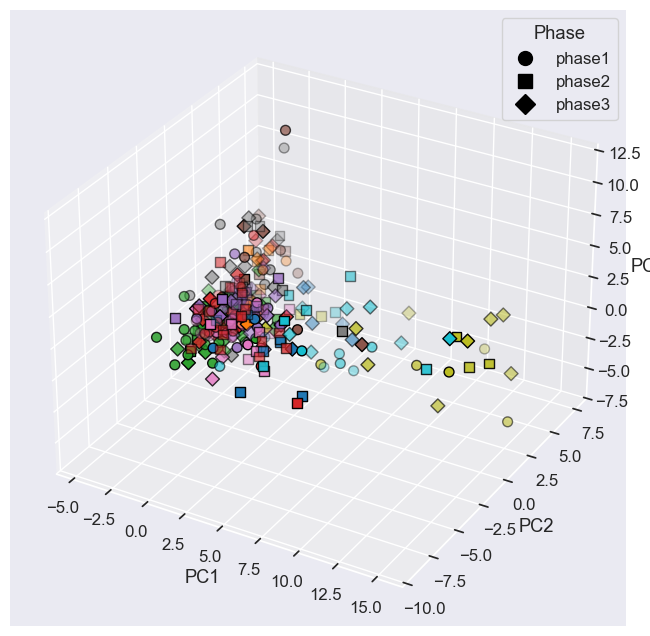

For the reduced data, the silhoutte score is: -0.013932641595602036


In [54]:
plot_data(data, ztrain, phase=phase_values[:data.shape[0]])
three_d_plot_data(data, ztrain, phase=phase_values[:data.shape[0]])

print(f"For the reduced data, the silhoutte score is: {silhouette_score(data, ztrain)}")